In [1]:
import pandas as pd
import finterstellar as fs

In [2]:
ld = fs.LoadData()
path = './data/'

포트폴리오 선정

In [3]:
# define universe
portfolio_dict = dict()
portfolio = {
    'World indices' : ['KOSPI 200', 'S&P 500', 'Nikkei 225', 'CSI 300']
}    # 포트폴리오를 딕셔너리 형태로 저장
p_name = 'World indices'   # 포트폴리오 집합 중 분석대상 포트폴리오의 이름 입력
p_cd = portfolio[p_name]    # 선택한 포트폴리오 내에서 처리대상 종목코드들을 지정

데이터 로딩

In [4]:
# make new file
prices_df = ld.create_portfolio_df(path, p_name, p_cd) 
# ld 모듈의 create_portfolio_df(폴더명, 포트폴리오 이름, 종목코드) 함수를 이용해 포트폴리오 전체 시세를 한번에 수집
prices_df.tail()

,KOSPI 200,S&P 500,Nikkei 225,CSI 300
Date,,,,
2019-04-22,285.87,2907.97,22217.90,4025.61
2019-04-23,286.47,2933.68,22259.74,4019.01
2019-04-24,283.70,2927.25,22200.00,4030.09
2019-04-25,282.83,2926.17,22307.58,3941.82
2019-04-26,281.34,2939.88,22258.73,3889.27


In [5]:
trd = fs.PairTrade()
# fs 라이브러리의 PairsTrade() 모듈을 호출에 trd로 지정

기준일자 세팅

In [6]:
# 기준일자 세팅
#base_date = '2018-01-01'
base_date = pd.Timestamp.today().date() - pd.DateOffset(years=1)    # 디폴트로 1년 전 세팅
base_date = trd.check_base_date(prices_df, base_date)
# check_base_date(데이터프레임, 기준일자) - 기준일자가 공휴일인지 체크하고, 공휴일이면 다음 영업일을 반환
base_date

Timestamp('2018-04-30 00:00:00')

R2 값 비교

In [7]:
comp_r2 = trd.compare_r2(prices_df, base_date, p_cd)
'''
    compare_r2(데이터프레임, 기준일자, [종목코드군]) 
    - [종목코드군] 내 종목 쌍 전체에 대해 회귀분석을 수행해서 R2 값 순서대로 결과 반환
'''
comp_r2.head(10)

,R2,Slope,Correlation
pair,,,
S&P 500 vs. Nikkei 225,47.88,5.8001,0.691986
KOSPI 200 vs. Nikkei 225,43.83,38.7690,0.662079
KOSPI 200 vs. CSI 300,34.70,11.0703,0.589052
S&P 500 vs. CSI 300,21.31,1.2419,0.461642
KOSPI 200 vs. S&P 500,16.83,2.8657,0.410196
Nikkei 225 vs. CSI 300,9.85,0.1007,0.313792


데이터구간 샘플링

In [8]:
pair = ['S&P 500', 'Nikkei 225']
sample = trd.sampling(prices_df, base_date, pair)
# sampling(데이터프레임, 기준일자, [종목명]) - 데이터프레임에서 지정한 종목의 기준일자 이후 데이터만 샘플링

회귀분석 수행

In [9]:
regr = trd.regression(sample, pair)
# regression(데이터프레임, [종목쌍]) - 데이터프레임의 종목쌍에 대해 회귀분석을 수행해 기울기, y절편, R2값 반환
regr

{'Slope': 5.800066348964079,
 'Intercept': 5966.376720564376,
 'R2': 0.47884514415203083}

CSI 300 지수가 x 일때 추세선에 따른 KOSPI 200 지수가 얼마이어야 하는지 구함

In [10]:
sample = trd.expected_y(sample, regr, pair)
# expected_y(데이터프레임, 회귀분석결과, [종목쌍]) - 회귀분석결과를 집어넣고 통계적인 y종목의 기대가격을 산출
sample.head()

,S&P 500,Nikkei 225,Nikkei 225 expected,Nikkei 225 spread
Date,,,,
2018-04-30,2648.05,22467.87,21325.242416,1142.627584
2018-05-01,2654.80,22508.03,21364.392864,1143.637136
2018-05-02,2635.67,22472.78,21253.437595,1219.342405
2018-05-03,2629.73,22472.78,21218.985200,1253.794800
2018-05-04,2663.42,22472.78,21414.389436,1058.390564


역치 세팅

In [11]:
# trading strategy determinants
threshold = 0.02   # percent 값으로 오차허용 구간을 정의
sample = trd.price_analyze(sample, threshold, pair)
# price_analyze(데이터프레임, 역치, [종목쌍]) - 역치값 대비 현재 가격의 고평가/저평가 여부 구분

            S&P 500  Nikkei 225  Nikkei 225 expected  Nikkei 225 spread
cheaper                                                                
E                98          98                   98                 98
Nikkei 225       86          86                   86                 86
S&P 500          77          77                   77                 77


# 백테스팅

트레이드북 생성

In [12]:
book = trd.create_trade_book(sample, pair)
# create_trade_book(데이터프레임, [종목쌍]) - 트레이딩북 생성
book.head()

,S&P 500,Nikkei 225,t S&P 500,p S&P 500,t Nikkei 225,p Nikkei 225
Date,,,,,,
2018-04-30,2648.05,22467.87,,,,
2018-05-01,2654.80,22508.03,,,,
2018-05-02,2635.67,22472.78,,,,
2018-05-03,2629.73,22472.78,,,,
2018-05-04,2663.42,22472.78,,,,


매일매일의 매매내역 기록

In [13]:
book = trd.tradings(sample, book, threshold, pair, short=True)
# tradings(데이터프레임, 트레이딩북, 역치, [종목코드쌍], 숏가능) - pair trade 매매전략을 이용한 백테스팅 수행

일자별 포지션 기록

In [14]:
book = trd.position(book, pair)
# position(트레이딩북, 종목코드) - 트레이딩 전략 수행에 수반되는 포지션 판단
book.tail()

,S&P 500,Nikkei 225,t S&P 500,p S&P 500,t Nikkei 225,p Nikkei 225
Date,,,,,,
2019-04-22,2907.97,22217.90,sell,ss,buy,ll
2019-04-23,2933.68,22259.74,sell,ss,buy,ll
2019-04-24,2927.25,22200.00,sell,ss,buy,ll
2019-04-25,2926.17,22307.58,sell,ss,buy,ll
2019-04-26,2939.88,22258.73,sell,ss,buy,ll


일자별 수익률 및 전체 수익률 계산

In [15]:
fund_rtn = trd.returns(book, pair, display=True)
# returns(트레이딩북, 종목코드) - 전략의 수익률 계산

2018-04-30 00:00:00 long S&P 500 2648.05
2018-05-30 00:00:00 long S&P 500 2648.05  | unwind long S&P 500 2724.01  | return: 1.0287
2018-05-31 00:00:00 long S&P 500 2705.27
2018-06-01 00:00:00 long S&P 500 2705.27  | unwind long S&P 500 2734.62  | return: 1.0108
2018-06-04 00:00:00 long S&P 500 2746.87
2018-06-19 00:00:00 long S&P 500 2746.87  | unwind long S&P 500 2762.59  | return: 1.0057
2018-06-20 00:00:00 long S&P 500 2767.32
2018-07-02 00:00:00 long S&P 500 2767.32  | unwind long S&P 500 2726.71  | return: 0.9853
2018-07-18 00:00:00 long S&P 500 2815.62
2018-07-23 00:00:00 long S&P 500 2815.62  | unwind long S&P 500 2806.98  | return: 0.9969
2018-08-01 00:00:00 long S&P 500 2813.36
2018-08-02 00:00:00 long S&P 500 2813.36  | unwind long S&P 500 2827.22  | return: 1.0049
2018-08-13 00:00:00 short S&P 500 2821.93
2018-08-14 00:00:00 short S&P 500 2821.93  | unwind short S&P 500 2839.96  | return: 0.9936
2018-09-18 00:00:00 long S&P 500 2904.31
2018-10-15 00:00:00 long S&P 500 2904.3

벤치마크 수익률 계산
(여기에서는 두 종목에 50%씩 분산투자하고 기간 중 계속 보유한 것으로 가정)

In [16]:
bm_rtn = trd.benchmark_return(book, pair)
# benchmark_return(트레이딩북, 종목코드) - 벤치마크 수익률 계산

BM return: 5.05 %
{'S&P 500': 1.1102, 'Nikkei 225': 0.9907}


페어트레이딩 전략의 초과수익률 계산

In [17]:
exs_rtn = trd.excess_return(fund_rtn, bm_rtn)
# excess_return(전략수익률, 벤치마크수익률) - 초과수익률 계산

Excess return: 58.8 %


In [18]:
# 참고 : 로그수익률
fund_rtn = trd.returns_log(book, pair)
# returns_log(트레이딩북, 종목코드) - 전략의 로그수익률 계산
bm_rtn = trd.benchmark_return_log(book, pair)
# benchmark_return(트레이딩북, 종목코드) - 벤치마크 수익률 계산
exs_rtn = trd.excess_return_log(fund_rtn, bm_rtn)
# excess_return(전략수익률, 벤치마크수익률) - 초과수익률 계산

Accunulated return : 52.15 %
BM return: 4.76 %
{'S&P 500': 10.4545, 'Nikkei 225': -0.9352}
Excess return: 47.39 %


그래프 모듈 호출

In [19]:
v = fs.Visualize()

()

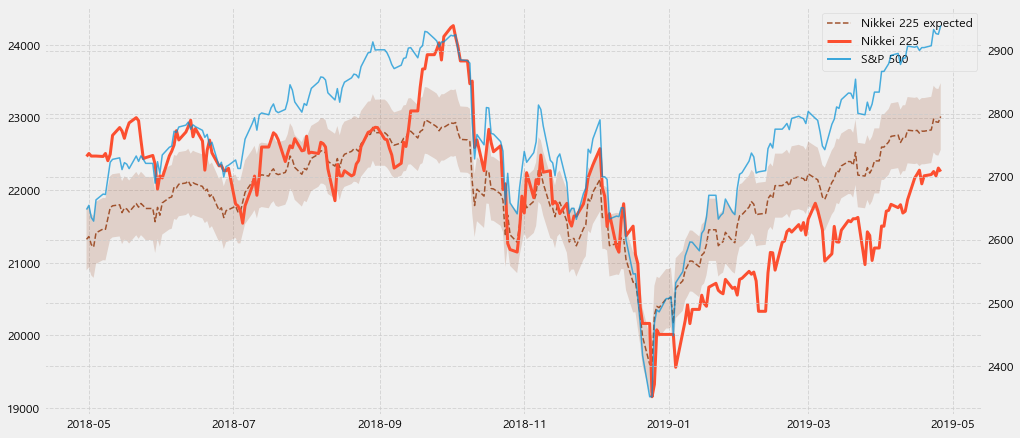

In [20]:
v.pair_trend_index_view(sample, threshold, pair)
# v 모듈의 pairs_trend_index_view(트레이딩북, 역치, [종목코드], (사이즈)) 함수 - pairs trade 그래프 그리기

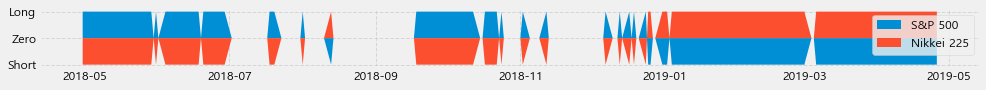

In [21]:
v.position_view(book, pair)
# v 모듈의 position_view(트레이딩북, 종목코드, (사이즈)) 함수 - 보유내역 그래프 그리기

주가 변동 내역

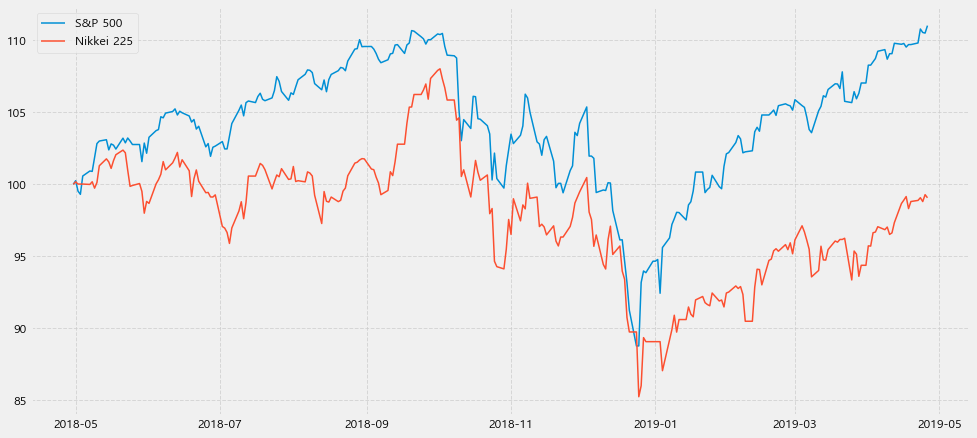

In [22]:
v.index_view(sample, base_date, pair)